# Electron-Photon

Information about the dataset: https://arxiv.org/abs/1807.11916

In [1]:
import jax

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_electron_photon_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-10-09 15:06:03.315563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 15:06:03.315593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 15:06:03.315619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 15:06:06.639486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U cirq`` to enable related functionality in translation module


In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-SXM4-40GB


Cardinalities (train, val, test): 439200 48800 10000
(32, 32, 2)


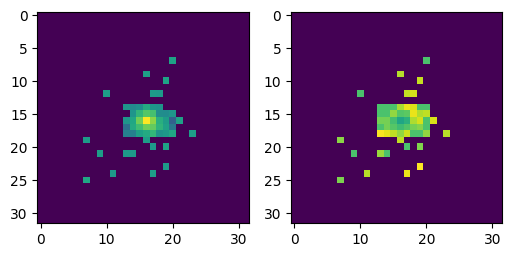

In [3]:
ep_train_dataloader, ep_valid_dataloader, ep_test_dataloader = get_electron_photon_dataloaders(batch_size=256, data_dir=data_dir)
first_image = next(iter(ep_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

In [4]:
model = VisionTransformer(num_classes=2, patch_size=8, hidden_size=6, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=3,
                          quantum_attn_circuit=get_circuit(), quantum_mlp_circuit=get_circuit())
test_loss, test_auc, test_fpr, test_tpr = train_and_evaluate(model, ep_train_dataloader, ep_valid_dataloader, ep_test_dataloader, num_classes=2, num_epochs=50)

Number of parameters = 1280


Epoch  50/50: 100%|██████████| 1715/1715 [00:52<00:00, 32.62batch/s, Loss = 0.6012, AUC = 73.94%]


Total training time = 2676.78s, best validation AUC = 73.94% at epoch 30


Testing: 100%|██████████| 39/39 [00:01<00:00, 21.47batch/s, Loss = 0.6076, AUC = 73.25%]


In [5]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=8, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=4,
                          quantum_attn_circuit=get_circuit(), quantum_mlp_circuit=get_circuit())
test_loss, test_auc, test_fpr, test_tpr = train_and_evaluate(model, ep_train_dataloader, ep_valid_dataloader, ep_test_dataloader, num_classes=2, num_epochs=50)

Number of parameters = 2290


Epoch  50/50: 100%|██████████| 1715/1715 [01:26<00:00, 19.74batch/s, Loss = 0.5846, AUC = 75.66%]


Total training time = 4388.94s, best validation AUC = 75.68% at epoch 26


Testing: 100%|██████████| 39/39 [00:01<00:00, 26.67batch/s, Loss = 0.5907, AUC = 75.30%]


---

In [6]:
import tensorcircuit as tc

In [7]:
def vqc_rot_xyz(c: tc.Circuit, inputs, weights):
    num_qubits = inputs.shape[-1]
    num_qlayers = weights.shape[-2]

    for i in range(num_qlayers):
        for j in range(num_qubits):
            c.r_gate(j, theta=weights[i, j, 0], alpha=weights[i, j, 1], phi=weights[i, j, 2])
        if num_qubits == 2:
            c.cnot(0, 1)
        elif num_qubits > 2:
            for j in range(num_qubits):
                c.cnot(j, (j + 1) % num_qubits)

In [8]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=8, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=4,
                          quantum_attn_circuit=get_circuit(), quantum_mlp_circuit=get_circuit())
test_loss, test_auc, test_fpr, test_tpr = train_and_evaluate(model, ep_train_dataloader, ep_valid_dataloader, ep_test_dataloader, num_classes=2, num_epochs=50)

Number of parameters = 2290


Epoch  50/50: 100%|██████████| 1715/1715 [01:26<00:00, 19.73batch/s, Loss = 0.5857, AUC = 75.59%]


Total training time = 4389.95s, best validation AUC = 75.62% at epoch 29


Testing: 100%|██████████| 39/39 [00:01<00:00, 27.24batch/s, Loss = 0.5912, AUC = 75.17%]
